In [1]:
from google.colab import files
files.upload()  # Choose kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"manukondarajdhanush","key":"6aceaf9e525e75efd5509636cc1ccaa8"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d mohitsingh1804/plantvillage


Dataset URL: https://www.kaggle.com/datasets/mohitsingh1804/plantvillage
License(s): GPL-2.0
 96% 788M/818M [00:04<00:00, 47.9MB/s]
100% 818M/818M [00:04<00:00, 197MB/s] 


In [4]:
!unzip -q plantvillage.zip -d PlantVillage


In [5]:
import os
print(os.listdir('PlantVillage'))


['PlantVillage']


In [6]:
import os
print(os.listdir("PlantVillage/PlantVillage"))


['train', 'val']


In [16]:
import os, cv2, time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, classification_report, confusion_matrix, cohen_kappa_score)


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from skimage.feature import hog, local_binary_pattern


In [11]:
TRAIN_DIR = "PlantVillage/PlantVillage/train"
VAL_DIR   = "PlantVillage/PlantVillage/val"


In [12]:
from skimage.feature import hog, local_binary_pattern
import cv2, os, numpy as np

def feature_generator(folder, method="hog"):
    features, labels = [], []
    for class_name in os.listdir(folder):
        class_path = os.path.join(folder, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    img = cv2.imread(img_path)
                    if img is not None:
                        img = cv2.resize(img, (128, 128))
                        img = img.astype("float32") / 255.0
                        gray = cv2.cvtColor((img*255).astype("uint8"), cv2.COLOR_BGR2GRAY)

                        if method == "hog":
                            feat = hog(gray, pixels_per_cell=(8,8), cells_per_block=(2,2), feature_vector=True)
                        elif method == "lbp":
                            lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
                            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 11), range=(0, 10))
                            feat = hist.astype("float") / (hist.sum() + 1e-7)
                        elif method == "edge":
                            edges = cv2.Canny(gray, 100, 200)
                            hist, _ = np.histogram(edges.ravel(), bins=32, range=(0, 256))
                            feat = hist.astype("float") / (hist.sum() + 1e-7)

                        features.append(feat)
                        labels.append(class_name)
    return np.array(features), np.array(labels)


In [13]:
print("Extracting HOG features...")
X_train_hog, y_train_hog = feature_generator(TRAIN_DIR, "hog")
X_val_hog,   y_val_hog   = feature_generator(VAL_DIR, "hog")

print("Extracting LBP features...")
X_train_lbp, y_train_lbp = feature_generator(TRAIN_DIR, "lbp")
X_val_lbp,   y_val_lbp   = feature_generator(VAL_DIR, "lbp")

print("Extracting Edge features...")
X_train_edge, y_train_edge = feature_generator(TRAIN_DIR, "edge")
X_val_edge,   y_val_edge   = feature_generator(VAL_DIR, "edge")

print("✅ Done: HOG", X_train_hog.shape, "| LBP", X_train_lbp.shape, "| Edge", X_train_edge.shape)


Extracting HOG features...
Extracting LBP features...
Extracting Edge features...
✅ Done: HOG (43444, 8100) | LBP (43444, 10) | Edge (43444, 32)


In [14]:
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}


In [17]:
# Step 1: Define classifiers
classifiers = {
    "LogisticRegression": LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DecisionTree": DecisionTreeClassifier(),
    "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# Step 2: Results list
results = []

# Step 3: Metrics function
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, average="weighted"),
        "Recall": recall_score(y_true, y_pred, average="weighted"),
        "F1": f1_score(y_true, y_pred, average="weighted"),
        "Kappa": cohen_kappa_score(y_true, y_pred)
    }

# Step 4: Evaluation function
def evaluate_features(X_train, y_train, X_val, y_val, feature_name):
    for name, clf in classifiers.items():
        start = time.time()
        clf.fit(X_train, y_train)
        preds = clf.predict(X_val)
        end = time.time()

        metrics = get_metrics(y_val, preds)
        metrics["Feature"] = feature_name
        metrics["Classifier"] = name
        metrics["Time (s)"] = round(end - start, 2)
        results.append(metrics)

        print(f"\n{name} with {feature_name}:")
        print(classification_report(y_val, preds))
        print("Cohen’s Kappa:", metrics["Kappa"])

# Step 5: Run on all features
evaluate_features(X_train_hog, y_train_hog, X_val_hog, y_val_hog, "HOG")
evaluate_features(X_train_lbp, y_train_lbp, X_val_lbp, y_val_lbp, "LBP")
evaluate_features(X_train_edge, y_train_edge, X_val_edge, y_val_edge, "Edge")

# Step 6: Collect results
df_results = pd.DataFrame(results)
print(df_results)



LogisticRegression with HOG:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.25      0.22      0.24       126
                                 Apple___Black_rot       0.68      0.62      0.65       125
                          Apple___Cedar_apple_rust       0.53      0.18      0.27        55
                                   Apple___healthy       0.44      0.46      0.45       329
                               Blueberry___healthy       0.54      0.55      0.54       300
          Cherry_(including_sour)___Powdery_mildew       0.82      0.72      0.77       210
                 Cherry_(including_sour)___healthy       0.83      0.76      0.79       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.59      0.44      0.50       103
                       Corn_(maize)___Common_rust_       0.95      0.95      0.95       239
               Corn_(maize)___Northern_Leaf_Bligh

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



RandomForest with HOG:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.81      0.10      0.18       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.32      0.16      0.21       329
                               Blueberry___healthy       0.60      0.18      0.27       300
          Cherry_(including_sour)___Powdery_mildew       0.66      0.17      0.27       210
                 Cherry_(including_sour)___healthy       0.79      0.09      0.16       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.71      0.10      0.17       103
                       Corn_(maize)___Common_rust_       0.97      0.99      0.98       239
               Corn_(maize)___Northern_Leaf_Blight       0.53      0.68      0.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


LogisticRegression with LBP:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       300
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                       Corn_(maize)___Common_rust_       0.85      0.69      0.76       239
               Corn_(maize)___Northern_Leaf_Bligh

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


LogisticRegression with Edge:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       300
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00       210
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00       103
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00       239
               Corn_(maize)___Northern_Leaf_Blig

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


KNN with Edge:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.00      0.00      0.00       329
                               Blueberry___healthy       0.00      0.00      0.00       300
          Cherry_(including_sour)___Powdery_mildew       0.10      0.00      0.01       210
                 Cherry_(including_sour)___healthy       0.07      0.05      0.05       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.08      0.03       103
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00       239
               Corn_(maize)___Northern_Leaf_Blight       0.20  

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/m


RandomForest with Edge:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.00      0.00      0.00       126
                                 Apple___Black_rot       0.00      0.00      0.00       125
                          Apple___Cedar_apple_rust       0.00      0.00      0.00        55
                                   Apple___healthy       0.04      0.02      0.02       329
                               Blueberry___healthy       0.06      0.05      0.05       300
          Cherry_(including_sour)___Powdery_mildew       0.02      0.00      0.01       210
                 Cherry_(including_sour)___healthy       0.13      0.06      0.08       170
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.02      0.01      0.01       103
                       Corn_(maize)___Common_rust_       0.01      0.00      0.01       239
               Corn_(maize)___Northern_Leaf_Blight    

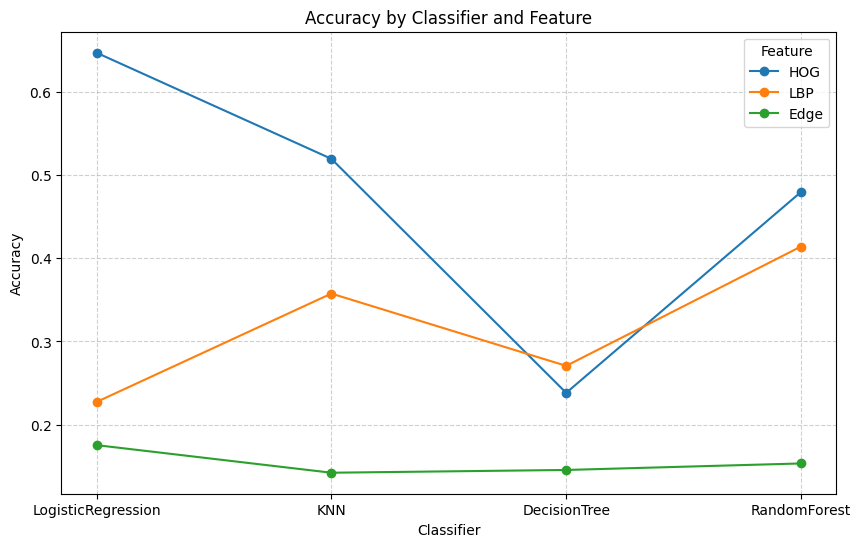

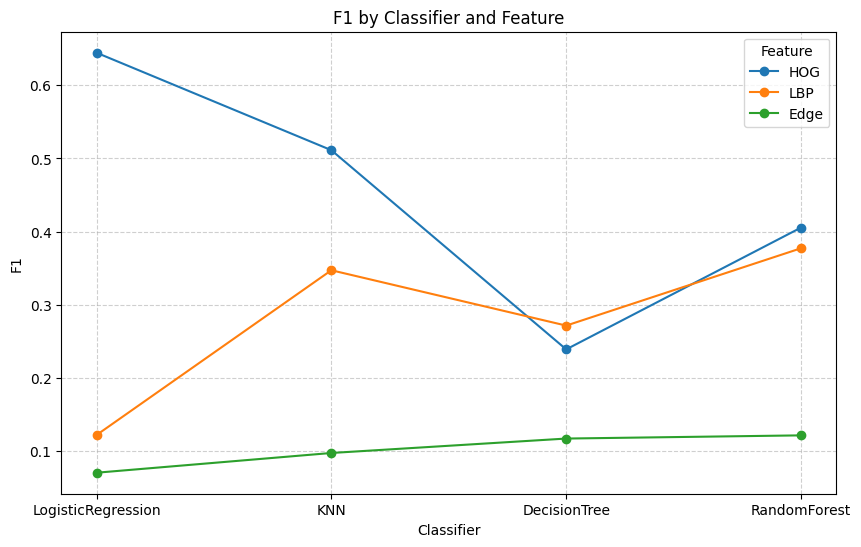

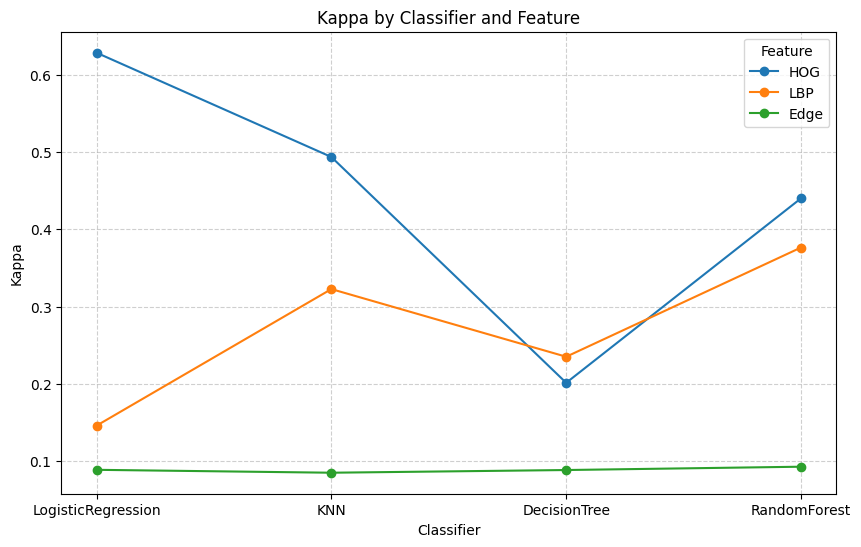

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Data from the user's results table
data = {
    "Accuracy": [0.646810, 0.519381, 0.238284, 0.479606, 0.227327, 0.357518, 0.270693, 0.414050, 0.175490, 0.142344, 0.145659, 0.153485],
    "F1": [0.644550, 0.511239, 0.238777, 0.405380, 0.121607, 0.347017, 0.271308, 0.377102, 0.070067, 0.097070, 0.116805, 0.121167],
    "Kappa": [0.628844, 0.493746, 0.201140, 0.440218, 0.145584, 0.322580, 0.234918, 0.376457, 0.088398, 0.084629, 0.088119, 0.092425],
    "Feature": ["HOG", "HOG", "HOG", "HOG", "LBP", "LBP", "LBP", "LBP", "Edge", "Edge", "Edge", "Edge"],
    "Classifier": ["LogisticRegression", "KNN", "DecisionTree", "RandomForest",
                   "LogisticRegression", "KNN", "DecisionTree", "RandomForest",
                   "LogisticRegression", "KNN", "DecisionTree", "RandomForest"]
}

df_results = pd.DataFrame(data)

# Plot Accuracy, F1, and Kappa
metrics = ["Accuracy", "F1", "Kappa"]
for metric in metrics:
    plt.figure(figsize=(10,6))
    for feature in df_results["Feature"].unique():
        subset = df_results[df_results["Feature"] == feature]
        plt.plot(subset["Classifier"], subset[metric], marker="o", label=feature)

    plt.title(f"{metric} by Classifier and Feature")
    plt.xlabel("Classifier")
    plt.ylabel(metric)
    plt.legend(title="Feature")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()
